### Preliminary operations

We import the libraries and extract the zip file into the Notebook environment.

In [1]:
# Utility
from shutil import copyfile, copy
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import pandas as pd
import numpy as np
import seaborn as sns

# Audio processing
import librosa
import librosa.display
import audiomentations

# Sklearn
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import joblib

# Keras
import keras
import tensorflow as tf
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Input, Dropout, Dense, Activation, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, BatchNormalization, LSTM, GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical

     

For each actor in audio dataset (RAVDESS_AUDIO) we count the audio files to check if the data is balanced.

In [2]:
data_list = os.listdir("Datasets/RAVDESS_AUDIO/")
data_list.sort()

count = [0] * 24
j = 0
for i in data_list:
  filename = os.listdir("Datasets/RAVDESS_AUDIO/" + i)
  for f in filename:
    if f.endswith('wav'): 
      count[j]+=1
  j+=1

In [3]:
count

[60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60]

We have 24 actors, each with 60 audio files. 

Now let's divide the audio files according to their labels. We will exclude the neutral emotion from our analysis due to limited data and its similarity to the calm emotion.

In [4]:
def switch(emotion):
  if emotion == 2:
    return 'calm'
  elif emotion == 3:
    return 'happy'
  elif emotion == 4:
    return 'sad'
  elif emotion == 5:
    return 'angry'
  elif emotion == 6:
    return 'fear'
  elif emotion == 7:
    return 'disgust'
  elif emotion == 8:
    return 'surprise'

In [5]:
emotion = []
path = []
for i in data_list:
  filename = os.listdir("Datasets/RAVDESS_AUDIO/" + i)
  for f in filename:
    # Remove wav extension
    id = f[:-4].split('-')
    if(id[2] != '01'):
      # Dividing according to emotions
      emotion.append(switch(int(id[2])))
      path.append("Datasets/RAVDESS_AUDIO/" + i + '/' + f)

In [6]:
df = pd.concat([pd.DataFrame(emotion), pd.DataFrame(path)], axis = 1)
df.columns = ['emotion', 'path']
df['emotion'].value_counts()

emotion
calm        192
happy       192
sad         192
angry       192
fear        192
disgust     192
surprise    192
Name: count, dtype: int64

The dataset is perfectly balanced.

Let's pick some audios for every emotion.

audio: [-6.0121356e-06 -5.4384614e-05 -1.9763097e-04 ... -1.7850363e-04
 -1.9221165e-04  0.0000000e+00]
audio shape: (91231,)
audio sampling rate: 22050


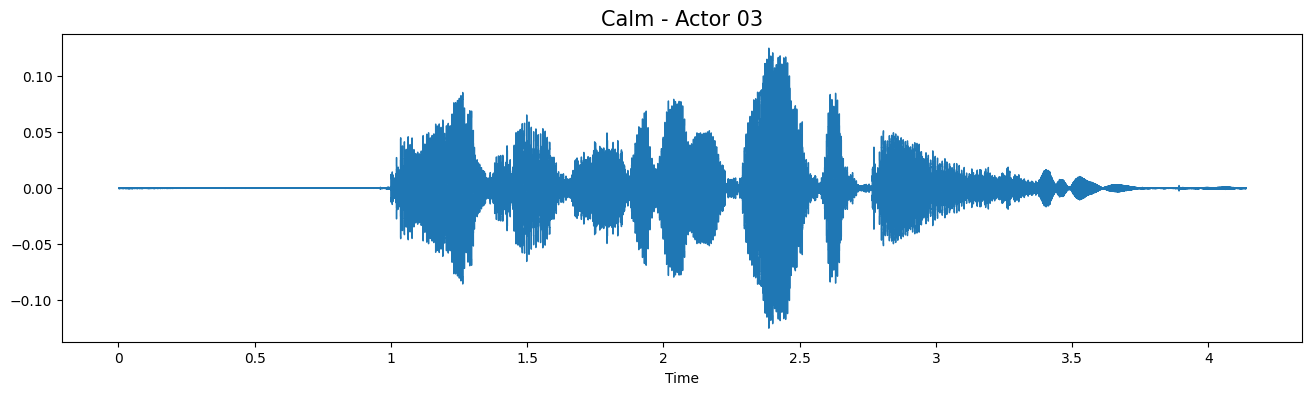

In [7]:
# Calm - Actor 03
filename = 'Datasets/RAVDESS_AUDIO/Actor_03/03-01-02-02-02-01-03.wav'  
audio, sampling_rate = librosa.load(filename)
print(f"audio: {audio}")
print(f"audio shape: {audio.shape}")
print(f"audio sampling rate: {sampling_rate}")
fig, ax = plt.subplots(figsize=(16,4))
librosa.display.waveshow(audio, sr = sampling_rate,ax=ax)
ax.set_title('Calm - Actor 03', fontsize=15)

ipd.Audio(filename)

audio: [6.3126495e-06 2.3600835e-04 6.3607504e-04 ... 6.9879832e-05 1.4470563e-04
 0.0000000e+00]
audio shape: (84610,)
audio sampling rate: 22050


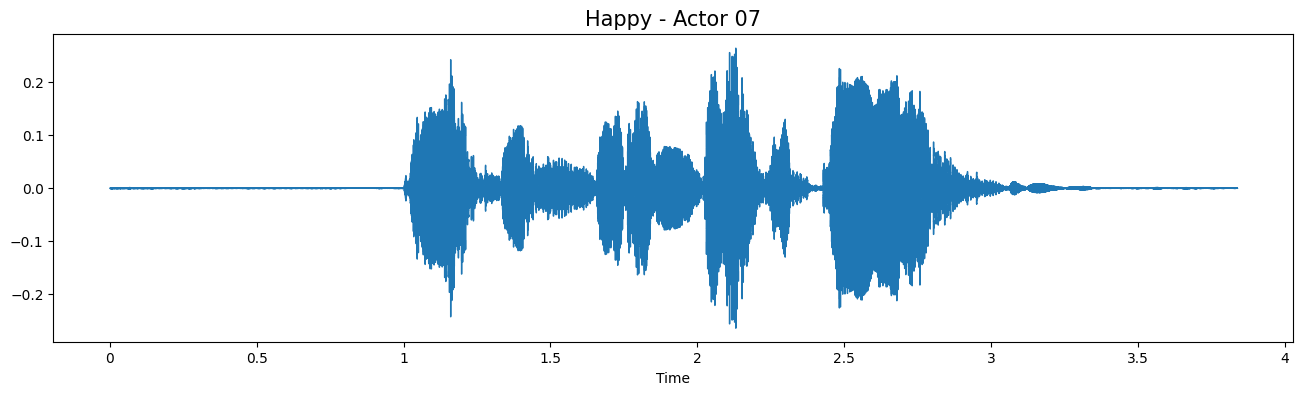

In [42]:
# Happy - Actor 07
filename = 'Datasets/RAVDESS_AUDIO/Actor_07/03-01-03-02-02-02-07.wav'  
audio, sampling_rate = librosa.load(filename)
print(f"audio: {audio}")
print(f"audio shape: {audio.shape}")
print(f"audio sampling rate: {sampling_rate}")
fig, ax = plt.subplots(figsize=(16,4))
librosa.display.waveshow(audio, sr = sampling_rate,ax=ax)
ax.set_title('Happy - Actor 07', fontsize=15)

ipd.Audio(filename)

audio: [-3.3588998e-07  3.4743670e-07 -3.2829797e-07 ... -1.3569232e-05
 -1.7149533e-06  0.0000000e+00]
audio shape: (80196,)
audio sampling rate: 22050


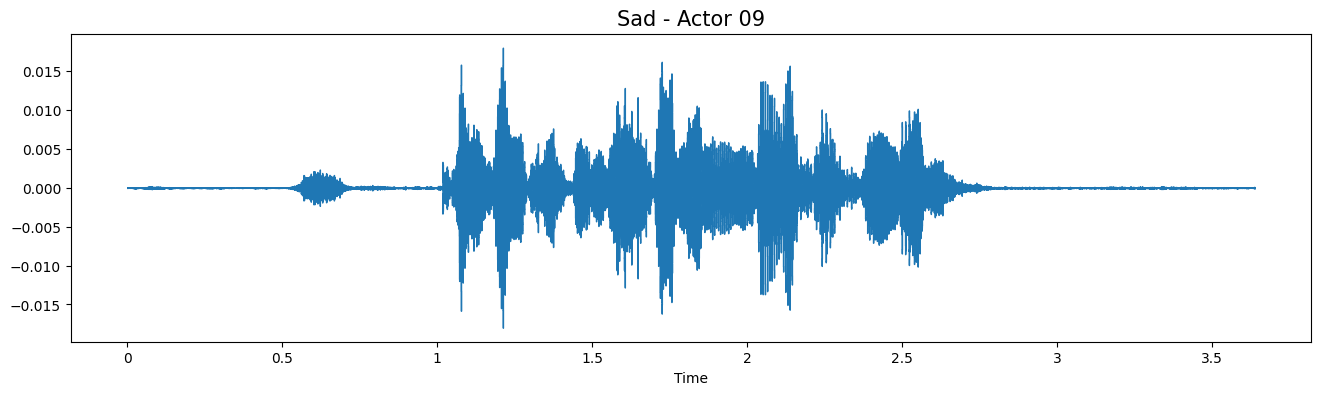

In [41]:
# Sad - Actor 9
filename = 'Datasets/RAVDESS_AUDIO/Actor_09/03-01-04-02-02-01-09.wav'  
audio, sampling_rate = librosa.load(filename)
print(f"audio: {audio}")
print(f"audio shape: {audio.shape}")
print(f"audio sampling rate: {sampling_rate}")
fig, ax = plt.subplots(figsize=(16,4))
librosa.display.waveshow(audio, sr = sampling_rate,ax=ax)
ax.set_title('Sad - Actor 09', fontsize=15)

ipd.Audio(filename)

We notice some initial noise due to the breath before speaking.

audio: [-4.9274760e-08  7.0194986e-08 -9.1008062e-08 ... -2.6591402e-04
 -2.9937358e-04  0.0000000e+00]
audio shape: (86817,)
audio sampling rate: 22050


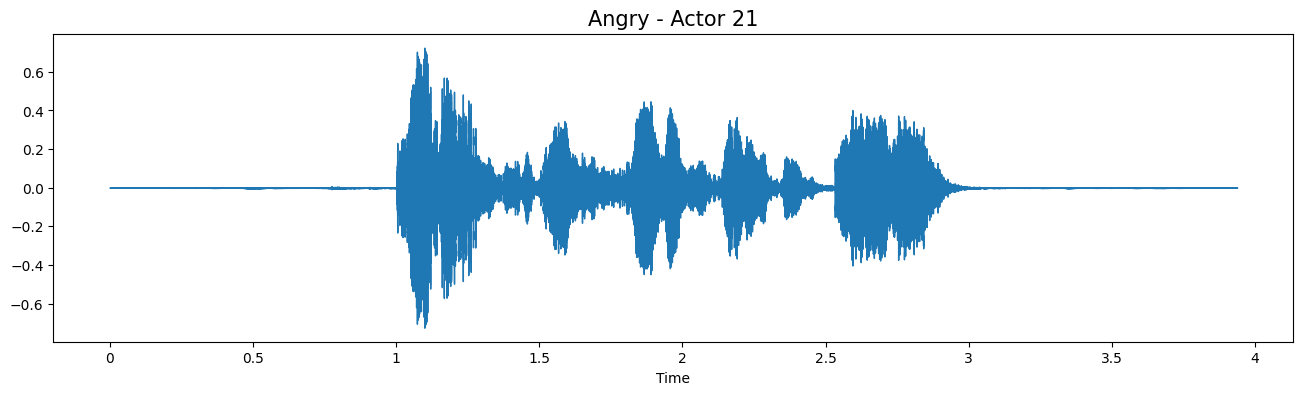

In [40]:
# Angry - Actor 21
filename = 'Datasets/RAVDESS_AUDIO/Actor_11/03-01-05-02-02-01-11.wav'  
audio, sampling_rate = librosa.load(filename)
print(f"audio: {audio}")
print(f"audio shape: {audio.shape}")
print(f"audio sampling rate: {sampling_rate}")
fig, ax = plt.subplots(figsize=(16,4))
librosa.display.waveshow(audio, sr = sampling_rate,ax=ax)
ax.set_title('Angry - Actor 21', fontsize=15)

ipd.Audio(filename)

audio: [1.5434567e-04 2.2804648e-04 1.9112874e-04 ... 2.7501543e-05 4.6619156e-05
 0.0000000e+00]
audio shape: (73574,)
audio sampling rate: 22050


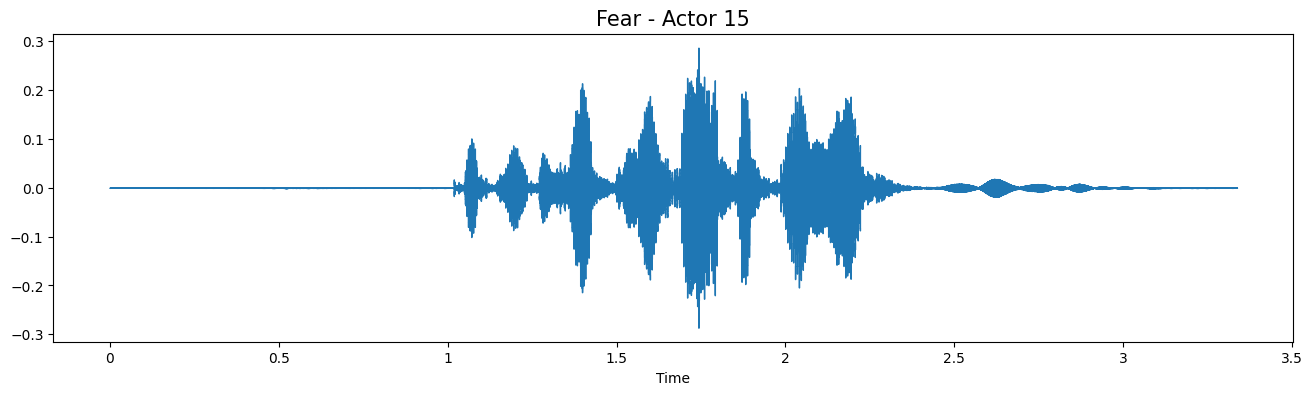

In [50]:
# Fear - Actor 15
filename = 'Datasets/RAVDESS_AUDIO/Actor_15/03-01-06-02-01-01-15.wav'  
audio, sampling_rate = librosa.load(filename)
print(f"audio: {audio}")
print(f"audio shape: {audio.shape}")
print(f"audio sampling rate: {sampling_rate}")
fig, ax = plt.subplots(figsize=(16,4))
librosa.display.waveshow(audio, sr = sampling_rate,ax=ax)
ax.set_title('Fear - Actor 15', fontsize=15)

ipd.Audio(filename)

audio: [0. 0. 0. ... 0. 0. 0.]
audio shape: (73574,)
audio sampling rate: 22050


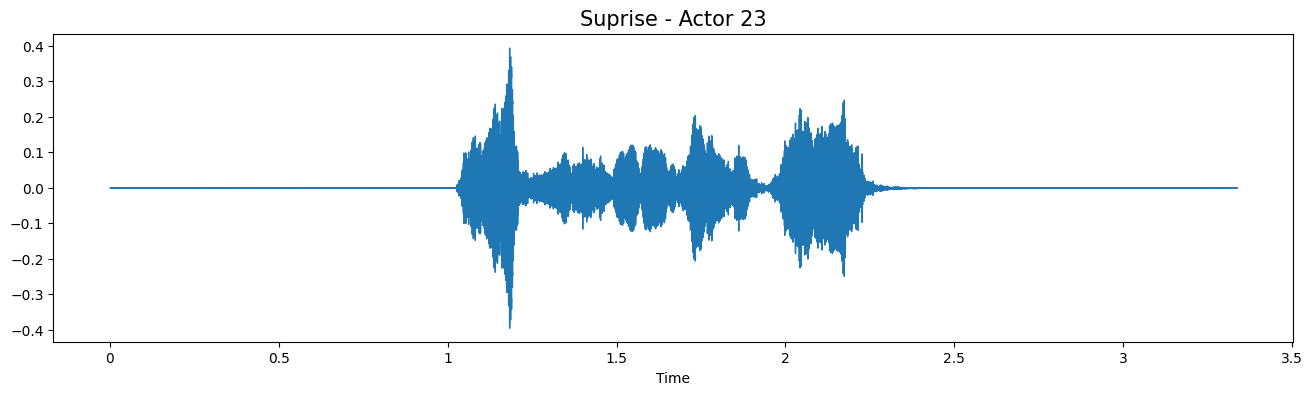

In [44]:
# Surprise - Actor 23
filename = 'Datasets/RAVDESS_AUDIO/Actor_23/03-01-08-02-02-01-23.wav'  
audio, sampling_rate = librosa.load(filename)
print(f"audio: {audio}")
print(f"audio shape: {audio.shape}")
print(f"audio sampling rate: {sampling_rate}")
fig, ax = plt.subplots(figsize=(16,4))
librosa.display.waveshow(audio, sr = sampling_rate,ax=ax)
ax.set_title('Suprise - Actor 23', fontsize=15)

ipd.Audio(filename)

We notice from the above two things:

- The duration for every audio file is about 3 seconds.
- There are some moments of silence at the beginning and at the end. We may remove them by picking just the central seconds.

Now, let's check the duration in samples for each statement and trim the audio files with 30 db threshold to reduce the silence parts.

In [7]:
trimmed = []
for filename in df['path']:
  y, sampling_rate = librosa.load(filename)
  y_trimmed, _ = librosa.effects.trim(y, top_db = 30)
  trimmed.append(y_trimmed)
df = pd.DataFrame(np.column_stack([df, trimmed]))
df.columns = ['emotion', 'path', 'data']

c:\Python310\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(v)


In [8]:
duration = []
for audio in df['data']:
  duration.append(audio.shape[0])
print(np.unique(duration))

[24064 25088 25600 26112 26624 27136 27648 28160 28672 29184 29696 30208
 30720 31232 31744 32256 32768 33280 33792 34304 34816 35328 35840 36352
 36864 37376 37888 38400 38912 39424 39936 40448 40960 41472 41984 42496
 43008 43520 44032 44544 45056 45568 46080 46592 47104 47616 48128 48640
 49152 49664 50176 50688 51046 51200 51712 52224 52582 52736 53248 53760
 54272 54784 55296 55808 56320 56420 56832 57344 57856 58368 58692 58880
 59392 59904 60163 60387 60416 60739 60834 60928 61440 61952 62370 62371
 62464 62976 63106 63488 63618 64000 65024 65313 65536 66048 66273 66560
 67072 67584 68608 69120 70144 70373 70656 71168 71680 72192 73216 73728
 75269 75776 76543 77661 77824 78336 78848 80896 93696]


Let's have a better view of the durations after the trimming.

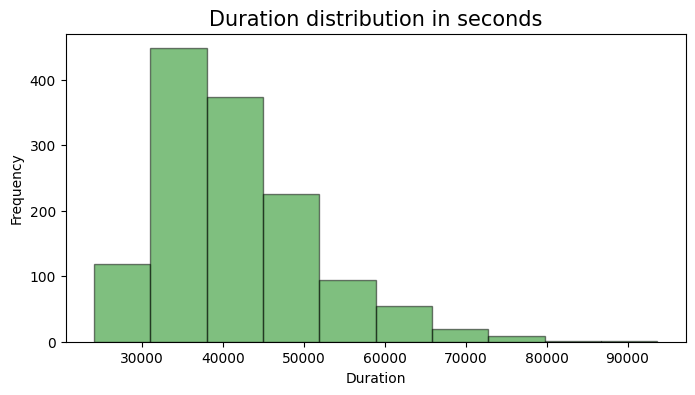

In [9]:
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(duration, alpha = 0.5, histtype = 'bar', ec = 'black', color='g')
ax.set_xlabel('Duration')
ax.set_ylabel('Frequency')
ax.set_title('Duration distribution in seconds', fontsize = 15)
plt.show()

In [10]:
print(f"Mean duration in samples is {round(np.mean(duration),2)}")
print(f"Minimum duration in samples is {np.min(duration)}")
print(f"Maximum duration in samples is {np.max(duration)}")

Mean duration in samples is 41630.16
Minimum duration in samples is 24064
Maximum duration in samples is 93696


## Data Preprocessing 

We pad with zeros the audio with length < Maximum duration

In [11]:
for i in range(df.shape[0]):
  if(len(df['data'][i]) != 93696):
    start_pad = (93696 - len(df['data'][i]))//2
    end_pad = 93696 - len(df['data'][i]) - start_pad
    df['data'][i] = np.pad(df['data'][i], (start_pad, end_pad), mode = 'constant')

Check if all the statements have the same length.

In [12]:
for i in range(df.shape[0]):
  if(len(df['data'][i]) != 93696):
    print(len(df['data'][i]))

Sample of a Plot Audio after the Preproccesing.

<AxesSubplot: >

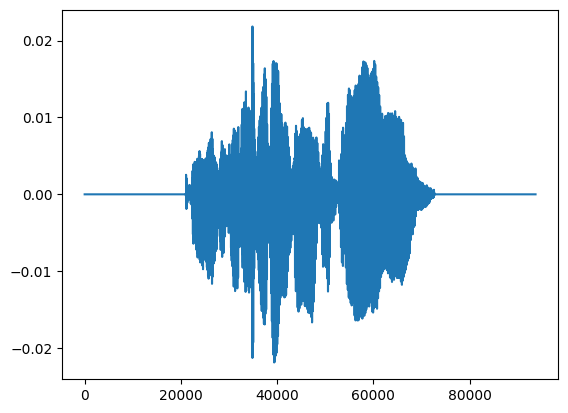

In [13]:
pd.Series(df['data'][1015]).plot()

## Feature extraction

We extract the log Mel spectrogram.

Let's see an example.

C:\Users\leofr\AppData\Local\Temp\ipykernel_17096\3864085772.py:1: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.power_to_db(librosa.feature.melspectrogram(df['data'][1]*1.0, sr = 48000, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000))


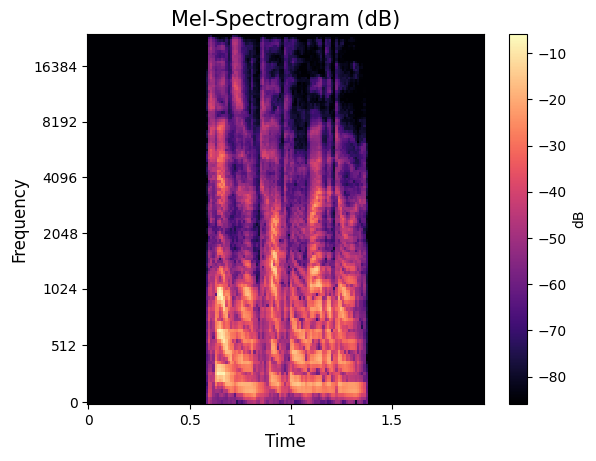

In [14]:
mel = librosa.power_to_db(librosa.feature.melspectrogram(df['data'][1]*1.0, sr = 48000, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000)) 
plt.figure()
librosa.display.specshow(mel, sr = 48000, x_axis = 'time', y_axis = 'mel', cmap = 'magma')
plt.colorbar(label = 'dB')
plt.title('Mel-Spectrogram (dB)', fontdict = dict(size = 15))
plt.xlabel('Time', fontdict = dict(size = 12))
plt.ylabel('Frequency', fontdict = dict(size = 12))
plt.show()

Initally, we build functions feature extraction via Mel spectrograms for 1D and 2D models.

Then we run them for every audio file of our dataset.

In [15]:
def feature_extractor_1D(input, feature, sr = 48000):
  # Mel Spectrogram
  if(feature == 'mel'):
    x = librosa.power_to_db(librosa.feature.melspectrogram(input*1.0, sr = sr, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000))
    return np.mean(x, axis = 0)      
  
def feature_extractor_2D(input, feature, sr = 48000):
  # Mel Spectrogram
  if(feature == 'mel'):
    return librosa.power_to_db(librosa.feature.melspectrogram(input*1.0, sr = sr, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000))

In [16]:
df['features_1D'] = [0] * df.shape[0]
for i in range(len(df)):
  mel_1D = feature_extractor_1D(df['data'][i], 'mel')
  df['features_1D'][i] = np.array(mel_1D, dtype = object)

df['features_2D'] = [0] * df.shape[0]
for i in range(len(df)):
  mel_2D = feature_extractor_2D(df['data'][i], 'mel')
  df['features_2D'][i] = np.array(mel_2D, dtype = object)

C:\Users\leofr\AppData\Local\Temp\ipykernel_17096\2282988618.py:4: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  x = librosa.power_to_db(librosa.feature.melspectrogram(input*1.0, sr = sr, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000))
C:\Users\leofr\AppData\Local\Temp\ipykernel_17096\914295608.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['features_1D'][i] = np.array(mel_1D, dtype = object)
C:\Users\leofr\AppData\Local\Temp\ipykernel_17096\2282988618.py:4: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  x = librosa.power_to_db(librosa.feature.melspectrogram(input*1.0, sr = sr, n_fft = 1024, n_m

In [17]:
print('We obtained a matrix with ' + str(df.shape[0]) + ' samples and ' + str(len(df['features_1D'][0])) + ' 1D features on.')
print('We obtained a matrix with ' + str(df.shape[0]) + ' samples and ' + str(len(df['features_2D'][0])) + ' 2D features on.')

We obtained a matrix with 1344 samples and 184 1D features on.
We obtained a matrix with 1344 samples and 128 2D features on.


We keep some samples for the test part of the model that will not be part of the augmented data.

In [18]:
df_1D = df[:1120]
df_2D = df[:1120]

### Data augmentation

This phase is performed in the following way;

1. We add noise for all the signals.
2. We pitch all the signals.
3. We stretch all the signals.
4. We shift all the signals.

In the end, we'll have the following data:

- Original dataset.
- Noise dataset.
- Pitch dataset.
- Stretch dataset.
- Shift dataset.

#### Noise

In [19]:
noise = audiomentations.Compose([
    audiomentations.AddGaussianNoise(p = 1)
])    

In [20]:
%%capture
df_1D['features_aug1_1D'] = [0] * 1120
for i in range(len(df_1D)):
  augmented_samples_1D = noise(df_1D['data'][i], 48000)
  mel_1D = feature_extractor_1D(augmented_samples_1D, 'mel')
  df_1D['features_aug1_1D'][i] = np.array(mel_1D, dtype = object)

df_2D['features_aug1_2D'] = [0] * 1120
for i in range(len(df_2D)):
  augmented_samples_2D = noise(df_2D['data'][i], 48000)
  mel_2D = feature_extractor_2D(augmented_samples_2D, 'mel')
  df_2D['features_aug1_2D'][i] = np.array(mel_2D, dtype = object) 

#### Pitch

In [21]:
pitchShift = audiomentations.Compose([
    audiomentations.PitchShift(p = 1)
])

In [22]:
%%capture
df_1D['features_aug2_1D'] = [0] * 1120
for i in range(len(df_1D)):
  augmented_samples_1D = pitchShift(df_1D['data'][i], 48000)
  mel_1D = feature_extractor_1D(augmented_samples_1D, 'mel')
  df_1D['features_aug2_1D'][i] = np.array(mel_1D, dtype = object)

df_2D['features_aug2_2D'] = [0] * 1120
for i in range(len(df_2D)):
  augmented_samples_2D = pitchShift(df_2D['data'][i], 48000)
  mel_2D = feature_extractor_2D(augmented_samples_2D, 'mel')
  df_2D['features_aug2_2D'][i] = np.array(mel_2D, dtype = object)

#### Stretch

In [23]:
stretch = audiomentations.Compose([
    audiomentations.TimeStretch(p = 1)
])

In [24]:
%%capture
df_1D['features_aug3_1D'] = [0] * 1120
for i in range(len(df_1D)):
  augmented_samples_1D = stretch(df_1D['data'][i], 48000)
  mel_1D = feature_extractor_1D(augmented_samples_1D, 'mel')
  df_1D['features_aug3_1D'][i] = np.array(mel_1D, dtype = object)    

df_2D['features_aug3_2D'] = [0] * 1120
for i in range(len(df_2D)):
  augmented_samples_2D = stretch(df_2D['data'][i], 48000)
  mel_2D = feature_extractor_2D(augmented_samples_2D, 'mel')
  df_2D['features_aug3_2D'][i] = np.array(mel_2D, dtype = object)      

#### Shift

In [25]:
shift = audiomentations.Compose([
    audiomentations.Shift(min_fraction = 0.25, max_fraction = 0.25, rollover = False, p = 1)
])

In [26]:
%%capture
df_1D['features_aug4_1D'] = [0] * 1120
for i in range(len(df_1D)):  
  augmented_samples_1D = shift(df_1D['data'][i], 48000)
  mel_1D = feature_extractor_1D(augmented_samples_1D, 'mel')
  df_1D['features_aug4_1D'][i] = np.array(mel_1D, dtype = object)

df_2D['features_aug4_2D'] = [0] * 1120
for i in range(len(df_2D)):  
  augmented_samples_2D = shift(df_2D['data'][i], 48000)
  mel_2D = feature_extractor_2D(augmented_samples_2D, 'mel')
  df_2D['features_aug4_2D'][i] = np.array(mel_2D, dtype = object)

Let's put together all the features with the related labels for the 1D and 2D features.


In [27]:
final_df_1D = pd.concat([
    pd.concat([df_1D['path'], df_1D['path'], df_1D['path'], df_1D['path'], df_1D['path']], axis = 0),
    pd.concat([df_1D['emotion'], df_1D['emotion'], df_1D['emotion'], df_1D['emotion'], df_1D['emotion']], axis = 0),
    pd.concat([df_1D['data'], df_1D['data'], df_1D['data'], df_1D['data'], df_1D['data']], axis = 0),
    pd.concat([df_1D['features_1D'], df_1D['features_aug1_1D'], df_1D['features_aug2_1D'], df_1D['features_aug3_1D'], df_1D['features_aug4_1D']], axis = 0)
], axis = 1)
final_df_1D.rename(columns = {0: 'features'}, inplace = True)
final_df_1D.reset_index (drop = True, inplace = True)
     

final_df_2D = pd.concat([
    pd.concat([df_2D['path'], df_2D['path'], df_2D['path'], df_2D['path'], df_2D['path']], axis = 0),
    pd.concat([df_2D['emotion'], df_2D['emotion'], df_2D['emotion'], df_2D['emotion'], df_2D['emotion']], axis = 0),
    pd.concat([df_2D['data'], df_2D['data'], df_2D['data'], df_2D['data'], df_2D['data']], axis = 0),
    pd.concat([df_2D['features_2D'], df_2D['features_aug1_2D'], df_2D['features_aug2_2D'], df_2D['features_aug3_2D'], df_2D['features_aug4_2D']], axis = 0)
], axis = 1)
final_df_2D.rename(columns = {0: 'features'}, inplace = True)
final_df_2D.reset_index (drop = True, inplace = True)

In [28]:
final_df_1D.head()

path emotion   
0  Datasets/RAVDESS_AUDIO/Actor_01/03-01-02-01-01...    calm  \
1  Datasets/RAVDESS_AUDIO/Actor_01/03-01-02-01-01...    calm   
2  Datasets/RAVDESS_AUDIO/Actor_01/03-01-02-01-02...    calm   
3  Datasets/RAVDESS_AUDIO/Actor_01/03-01-02-01-02...    calm   
4  Datasets/RAVDESS_AUDIO/Actor_01/03-01-02-02-01...    calm   

                                                data   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  \
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                            features  
0  [-88.81249237060547, -88.81249237060547, -88.8...  
1  [-85.87854766845703, -85.87854766845703, -85.8...  
2  [-87.85093688964844, -87.85093688964844, -87.8...  
3  [-87.8332748413086, -87.8332748413086, -87.833...  
4  [-90.87295532226562, -90.87295532226562, -90.8...

In [29]:
final_df_2D.head()

path emotion   
0  Datasets/RAVDESS_AUDIO/Actor_01/03-01-02-01-01...    calm  \
1  Datasets/RAVDESS_AUDIO/Actor_01/03-01-02-01-01...    calm   
2  Datasets/RAVDESS_AUDIO/Actor_01/03-01-02-01-02...    calm   
3  Datasets/RAVDESS_AUDIO/Actor_01/03-01-02-01-02...    calm   
4  Datasets/RAVDESS_AUDIO/Actor_01/03-01-02-02-01...    calm   

                                                data   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  \
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                            features  
0  [[-88.81245422363281, -88.81245422363281, -88....  
1  [[-85.87843322753906, -85.87843322753906, -85....  
2  [[-87.8510513305664, -87.8510513305664, -87.85...  
3  [[-87.83328247070312, -87.83328247070312, -87....  
4  [[-90.872802734375, -90.872802734375, -90.8728...

In [30]:
print('We obtained a matrix with ' + str(len(final_df_1D)) + ' samples and ' + str(len(final_df_1D['features'][0])) + ' features on 1D.')
print('We obtained a matrix with ' + str(len(final_df_2D)) + ' samples and ' + str(len(final_df_2D['features'][0])) + ' features on 2D.')

We obtained a matrix with 5600 samples and 184 features on 1D.
We obtained a matrix with 5600 samples and 128 features on 2D.


### Split train-test for CNN1D-LSTM

The data preparation steps for training and testing a CNN1D-LSTM model demonstrates as follows:

1. Data Split
2. Feature Standardization
3. Data Conversion
4. One-Hot Encoding
5. Dimension Expansion

In [57]:
X_train =  final_df_1D['features'].tolist()
y_train = final_df_1D['emotion'].tolist()

#We retrieve the test samples before the augmentation
X_test = df['features_1D'][1120:1344]
y_test = df['emotion'][1120:1344]
X_test.reset_index(inplace = True, drop = True)
y_test.reset_index(inplace = True, drop = True)

X_test = X_test.tolist()
y_test = y_test.tolist()

In [58]:
for i in range(len(X_train)):
  X_train[i] = X_train[i].astype(np.float64)
for i in range(len(X_test)):
  X_test[i] = X_test[i].astype(np.float64)

scaler = StandardScaler()
X_train[:1120] = scaler.fit_transform(X_train[:1120])
X_train[1120:] = scaler.transform(X_train[1120:])
X_test = scaler.transform(X_test)

In [59]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [60]:
# One-hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [61]:
# Making data compatible for the model
X_train = np.expand_dims(X_train, axis = 2)
X_test = np.expand_dims(X_test, axis = 2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5600, 184, 1), (5600, 7), (224, 184, 1), (224, 7))

### Model 0: CNN1-LSTM

In this preliminary model we use the data "vanilla" (i.e. not augmented).

In [71]:
X_train_vanilla = X_train[:896]
y_train_vanilla = y_train[:896]
X_val = X_train[896:1120]
y_val = y_train[896:1120]
X_train_vanilla.shape, y_train_vanilla.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((896, 282, 1), (896, 7), (224, 282, 1), (224, 7), (224, 282, 1), (224, 7))

We instanciate our first model with 4 Conv1D layers, 2 LSTM layers, 2 Dense layers, ReLU activations and MaxPooling1D. The output will be provided by the softmax function.

In [72]:
num_classes = 7

model0 = Sequential()

model0.add(Conv1D(64, 3, activation = 'relu', input_shape = (X_train_vanilla.shape[1], X_train_vanilla.shape[2])))
model0.add(BatchNormalization())
model0.add(MaxPooling1D(pool_size=(3), strides=(2), padding='same'))

model0.add(Conv1D(128, 3, activation = 'relu'))
model0.add(BatchNormalization())
model0.add(MaxPooling1D(pool_size=(3), strides=(2), padding='same'))
model0.add(Dropout(0.2))

model0.add(Conv1D(128, 3, activation = 'relu'))
model0.add(BatchNormalization())
model0.add(MaxPooling1D(pool_size=(3), strides=(2), padding='same'))
model0.add(Dropout(0.2))

model0.add(Conv1D(64, 3, activation='relu'))
model0.add(BatchNormalization())
model0.add(MaxPooling1D(pool_size=(3), strides=(2), padding='same'))
model0.add(Dropout(0.2))

model0.add(LSTM(64, return_sequences=True))
model0.add(LSTM(64))

model0.add(Dense(128, activation = 'relu'))

model0.add(Dense(num_classes, activation = 'softmax'))

model0.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_37 (Conv1D)          (None, 280, 64)           256       
                                                                 
 batch_normalization_13 (Bat  (None, 280, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 140, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_38 (Conv1D)          (None, 138, 128)          24704     
                                                                 
 batch_normalization_14 (Bat  (None, 138, 128)         512       
 chNormalization)                                                
                                                     

Training using the categorical cross-entropy loss function, the Adam optimizer with a learning rate of 0.001, and the accuracy metric for evaluation. The model is trained for 100 epochs with a batch size of 32. The training history is stored in the history0 variable.

In [73]:
model0.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history0 = model0.fit(X_train_vanilla, y_train_vanilla, batch_size = 32, epochs = 100, validation_data = (X_val, y_val))

Epoch 1/100
28/28 [==============================] - 7s 132ms/step - loss: 1.7857 - accuracy: 0.2757 - val_loss: 1.9002 - val_accuracy: 0.2321
Epoch 2/100
28/28 [==============================] - 3s 103ms/step - loss: 1.6049 - accuracy: 0.3650 - val_loss: 2.1333 - val_accuracy: 0.1384
Epoch 3/100
28/28 [==============================] - 3s 102ms/step - loss: 1.4964 - accuracy: 0.4118 - val_loss: 2.4842 - val_accuracy: 0.1696
Epoch 4/100
28/28 [==============================] - 3s 102ms/step - loss: 1.4307 - accuracy: 0.4453 - val_loss: 2.7053 - val_accuracy: 0.1429
Epoch 5/100
28/28 [==============================] - 3s 103ms/step - loss: 1.3648 - accuracy: 0.4632 - val_loss: 2.9084 - val_accuracy: 0.1161
Epoch 6/100
28/28 [==============================] - 3s 104ms/step - loss: 1.3495 - accuracy: 0.4821 - val_loss: 2.8479 - val_accuracy: 0.1384
Epoch 7/100
28/28 [==============================] - 3s 104ms/step - loss: 1.2794 - accuracy: 0.4911 - val_loss: 3.0689 - val_accuracy: 0.1161

Visualization of the training and validation loss, as well as the training and validation accuracy over the epochs.

7/7 [==============================] - 0s 36ms/step - loss: 3.5245 - accuracy: 0.4554
Accuracy of our model on validation data :  45.53571343421936 %


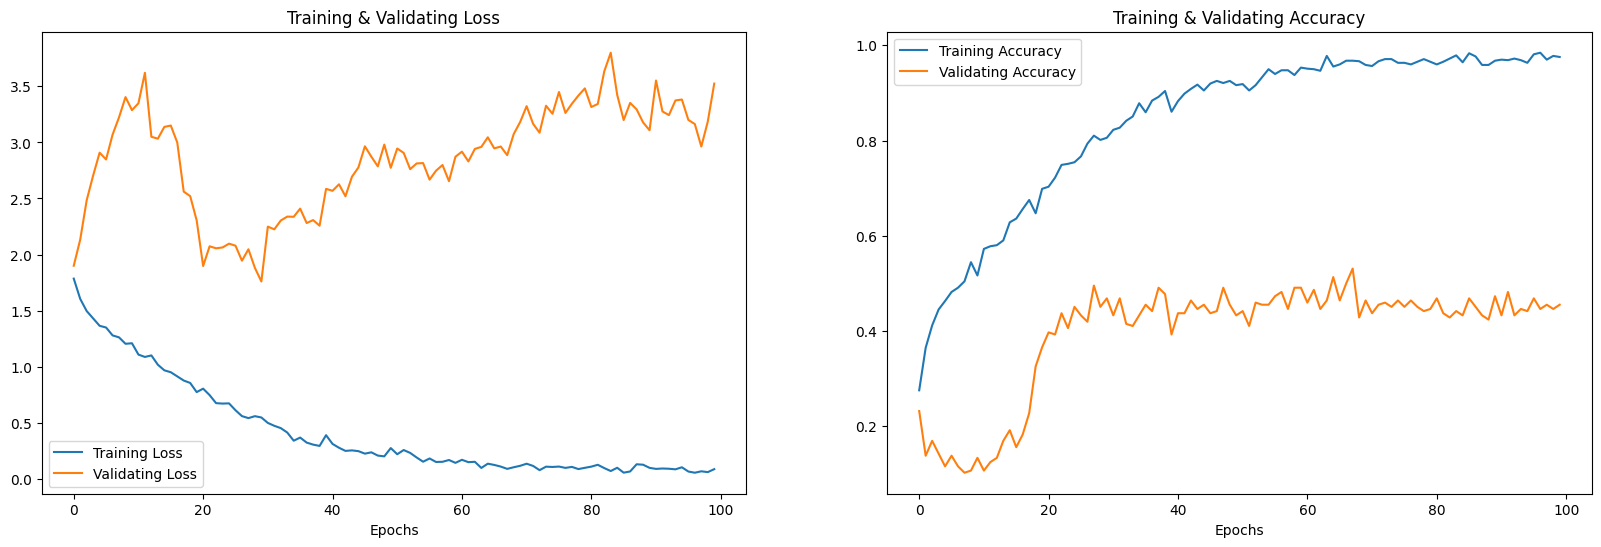

In [74]:
print("Accuracy of our model on validation data : " , model0.evaluate(X_val,y_val)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history0.history['accuracy']
train_loss = history0.history['loss']
val_acc = history0.history['val_accuracy']
val_loss = history0.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , val_loss , label = 'Validating Loss')
ax[0].set_title('Training & Validating Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , val_acc , label = 'Validating Accuracy')
ax[1].set_title('Training & Validating Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

Classification report to provide an overview of the model's performance, including metrics such as precision, recall, F1-score, and support for each class.

In [75]:
y_pred = model0.predict(X_val)
y_pred_ = np.argmax(y_pred, axis = 1)
y_val_ = np.argmax(y_val, axis = 1)
print(classification_report(y_val_, y_pred_))

7/7 [==============================] - 1s 33ms/step
              precision    recall  f1-score   support

           0       0.40      0.59      0.48        32
           1       0.62      0.75      0.68        32
           2       0.53      0.81      0.64        32
           3       0.29      0.28      0.29        32
           4       0.44      0.25      0.32        32
           5       0.40      0.25      0.31        32
           6       0.42      0.25      0.31        32

    accuracy                           0.46       224
   macro avg       0.44      0.46      0.43       224
weighted avg       0.44      0.46      0.43       224



An easy visual inspection of the model's predictions against the ground truth labels.

In [79]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(df['emotion']).reshape(-1,1)).toarray()

# predicting on test data.
pred_val = model0.predict(X_val)
y_pred_ = encoder.inverse_transform(pred_val)
y_val_ = encoder.inverse_transform(y_val)

df_new = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_new['Predicted Labels'] = y_pred_.flatten()
df_new['Actual Labels'] = y_val_.flatten()

df_new

7/7 [==============================] - 0s 37ms/step


Predicted Labels Actual Labels
0              happy          calm
1                sad          calm
2            disgust          calm
3            disgust          calm
4                sad          calm
..               ...           ...
219             fear      surprise
220             fear      surprise
221             fear      surprise
222             fear      surprise
223             fear      surprise

[224 rows x 2 columns]

The resulting heatmap provides a visual representation of the confusion matrix, allowing for a quick understanding of the model's performance. Each cell in the heatmap represents the number of occurrences where the predicted label and the actual label coincide. 

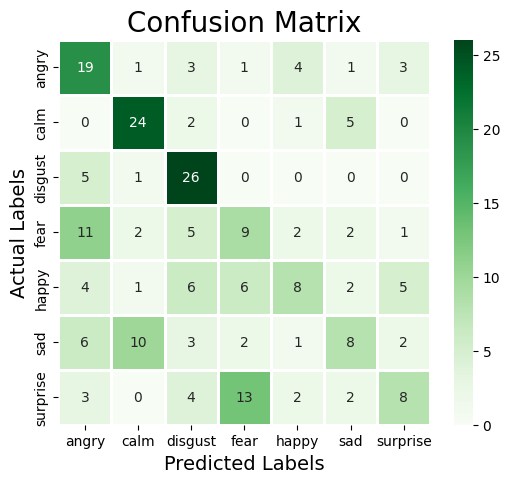

In [80]:
cm = confusion_matrix(y_val_, y_pred_)
plt.figure(figsize = (6, 5))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Greens', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

The top-k accuracy metric evaluates the model's performance by considering whether the true label falls within the k highest predicted labels.

In [81]:
print(top_k_accuracy_score(y_val_, y_pred, k = 2))
print(top_k_accuracy_score(y_val_, y_pred, k = 3))

0.6517857142857143
0.7991071428571429


### Split train-test for CNN2D

Same preparation steps for training and testing a CNN2D model.

We load and normalize the data.

In [31]:
X_train =  final_df_2D['features'].tolist()
y_train = final_df_2D['emotion'].tolist()

#We retrieve the test samples before the augmentation
X_test = df['features_2D'][1120:1344]
y_test = df['emotion'][1120:1344]
X_test.reset_index(inplace = True, drop = True) 
y_test.reset_index(inplace = True, drop = True)

X_test = X_test.tolist()
y_test = y_test.tolist()

In [32]:
for i in range(len(X_train)):
  X_train[i] = X_train[i].astype(np.float64)
for i in range(len(X_test)):
  X_test[i] = X_test[i].astype(np.float64)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

scaler_train = StandardScaler()

# We compute the mean and std dev for the features to be used further for scaling.
X_train[:1120] = scaler_train.fit_transform(X_train[:1120].reshape(-1, X_train.shape[-1])).reshape(X_train[:1120].shape)
#We don't want the augmented data and test data to introduce bias to fit() methoed of StandardScaler. We use the transform() method directly on the these data.
X_train[1120:] = scaler_train.transform(X_train[1120:].reshape(-1, X_train.shape[-1])).reshape(X_train[1120:].shape) 
X_test = scaler_train.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

Saving scaler for demo purpose in folder "Other/audio_test".

In [95]:
joblib.dump(scaler_train, 'Other/audio_test/std_scaler.bin')

['Other/audio_demo/std_scaler.bin']

In [33]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [34]:
# One-hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [35]:
# Making data compatible for the model
X_train = np.expand_dims(X_train, axis = 3)
X_test = np.expand_dims(X_test, axis = 3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5600, 128, 184, 1), (5600, 7), (224, 128, 184, 1), (224, 7))

Saving test data for demo purpose in folder "Other/audio_test".

In [99]:
np.save('Other/audio_test/X_test', X_test)
np.save('Other/audio_test/y_test', y_test)
df=0

### Model 1: CNN2D
In this model we also use the data "vanilla" (i.e. not augmented).

In [36]:
X_train_vanilla = X_train[:896]
y_train_vanilla = y_train[:896]
X_val = X_train[896:1120]
y_val = y_train[896:1120]
X_train_vanilla.shape, y_train_vanilla.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((896, 128, 184, 1),
 (896, 7),
 (224, 128, 184, 1),
 (224, 7),
 (224, 128, 184, 1),
 (224, 7))

We instanciate our CNN2D model with 4 Conv2D layers, 2 Dense layers, ReLU activations and MaxPooling2D. The output will be provided by the softmax function.

In [37]:
num_classes = 7

model1=Sequential()
model1.add(Conv2D(64, (3,3), activation='relu', input_shape=(X_train.shape[1],X_train.shape[2],1)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

model1.add(Conv2D(128, (3,3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
model1.add(Dropout(0.2))

model1.add(Conv2D(128, (3,3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
model1.add(Dropout(0.2))

model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
model1.add(Dropout(0.2))

model1.add(Flatten())

model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.2))
model1.add(BatchNormalization())

model1.add(Dense(num_classes, activation='softmax'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 182, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 126, 182, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 91, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 89, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 89, 128)      512       
 hNormalization)                                                 
                                                        

Training using the categorical cross-entropy loss function, the Adam optimizer with a learning rate of 0.001, and the accuracy metric for evaluation. The model is trained for 100 epochs with a batch size of 16. The training history is stored in the history1 variable.

In [38]:
model1.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history1 = model1.fit(X_train_vanilla, y_train_vanilla, batch_size = 16, epochs = 100, validation_data = (X_val, y_val))

Epoch 1/100
56/56 [==============================] - 37s 647ms/step - loss: 1.8561 - accuracy: 0.3181 - val_loss: 2.3863 - val_accuracy: 0.2009
Epoch 2/100
56/56 [==============================] - 36s 635ms/step - loss: 1.6351 - accuracy: 0.3460 - val_loss: 3.1823 - val_accuracy: 0.1741
Epoch 3/100
56/56 [==============================] - 35s 630ms/step - loss: 1.5141 - accuracy: 0.4174 - val_loss: 5.0514 - val_accuracy: 0.1920
Epoch 4/100
56/56 [==============================] - 36s 643ms/step - loss: 1.4714 - accuracy: 0.4319 - val_loss: 6.1390 - val_accuracy: 0.1786
Epoch 5/100
56/56 [==============================] - 36s 636ms/step - loss: 1.3538 - accuracy: 0.4922 - val_loss: 10.7832 - val_accuracy: 0.1339
Epoch 6/100
56/56 [==============================] - 35s 626ms/step - loss: 1.2837 - accuracy: 0.5223 - val_loss: 5.6811 - val_accuracy: 0.1786
Epoch 7/100
56/56 [==============================] - 35s 626ms/step - loss: 1.2239 - accuracy: 0.5491 - val_loss: 2.7129 - val_accuracy

Visualization of the training and validation loss, as well as the training and validation accuracy over the epochs.

7/7 [==============================] - 2s 255ms/step - loss: 2.3921 - accuracy: 0.5357
Accuracy of our model on validation data :  53.57142686843872 %


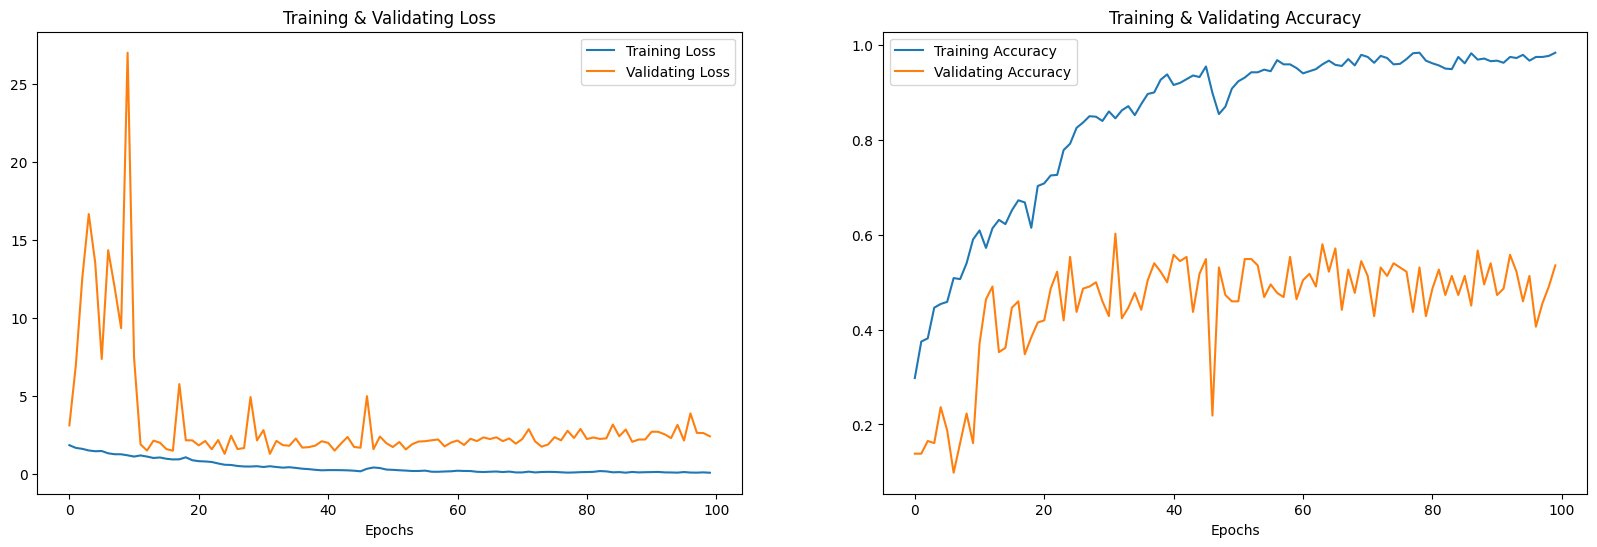

In [40]:
print("Accuracy of our model on validation data : " , model1.evaluate(X_val,y_val)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history1.history['accuracy']
train_loss = history1.history['loss']
val_acc = history1.history['val_accuracy']
val_loss = history1.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , val_loss , label = 'Validating Loss')
ax[0].set_title('Training & Validating Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , val_acc , label = 'Validating Accuracy')
ax[1].set_title('Training & Validating Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

Classification report to provide an overview of the model's performance, including metrics such as precision, recall, F1-score, and support for each class.

In [41]:
y_pred = model1.predict(X_val)
y_pred_ = np.argmax(y_pred, axis = 1)
y_val_ = np.argmax(y_val, axis = 1)
print(classification_report(y_val_, y_pred_))

7/7 [==============================] - 2s 252ms/step
              precision    recall  f1-score   support

           0       0.83      0.59      0.69        32
           1       0.62      0.75      0.68        32
           2       0.54      0.88      0.67        32
           3       0.32      0.59      0.41        32
           4       0.58      0.22      0.32        32
           5       0.39      0.22      0.28        32
           6       0.80      0.50      0.62        32

    accuracy                           0.54       224
   macro avg       0.58      0.54      0.52       224
weighted avg       0.58      0.54      0.52       224



An easy visual inspection of the model's predictions against the ground truth labels.

In [42]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(df['emotion']).reshape(-1,1)).toarray()

# predicting on test data.
pred_val = model1.predict(X_val)
y_pred_ = encoder.inverse_transform(pred_val)
y_val_ = encoder.inverse_transform(y_val)

df_new = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_new['Predicted Labels'] = y_pred_.flatten()
df_new['Actual Labels'] = y_val_.flatten()

df_new

7/7 [==============================] - 2s 254ms/step


Predicted Labels Actual Labels
0               calm          calm
1              happy          calm
2               calm          calm
3               fear          calm
4               calm          calm
..               ...           ...
219         surprise      surprise
220         surprise      surprise
221         surprise      surprise
222          disgust      surprise
223             fear      surprise

[224 rows x 2 columns]

The resulting heatmap provides a visual representation of the confusion matrix, allowing for a quick understanding of the model's performance. Each cell in the heatmap represents the number of occurrences where the predicted label and the actual label coincide. 

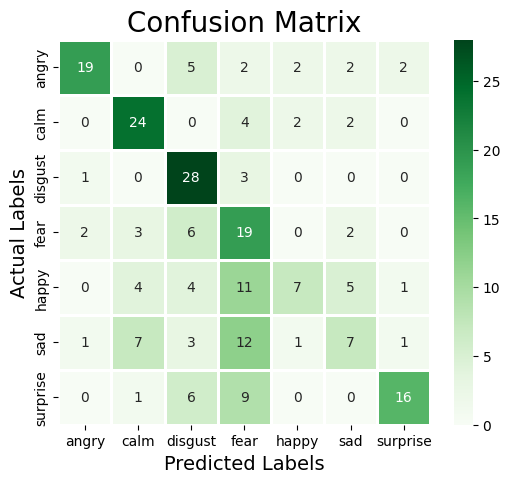

In [43]:
cm = confusion_matrix(y_val_, y_pred_)
plt.figure(figsize = (6, 5))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Greens', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

The top-k accuracy metric evaluates the model's performance by considering whether the true label falls within the k highest predicted labels.

In [53]:
print(top_k_accuracy_score(y_val_, y_pred, k = 2))
print(top_k_accuracy_score(y_val_, y_pred, k = 3))

0.7678571428571429
0.8660714285714286


### Model 1.2: CNN2D - AUGMENTED DATA
Now let's return to the CNN2D model and compare the performances if we use augmented data.

In [37]:
X_val = X_train[896:1120]
y_val = y_train[896:1120]
# We don't have to pick the validation data augmented
to_remove = list(range(896, 1120)) + list(range(2016, 2240)) + list(range(3136, 3360)) + list(range(4256, 4480)) + list(range(5376, 5600)) 
X_train = np.delete(X_train, to_remove, axis = 0)
y_train = np.delete(y_train, to_remove, axis = 0)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4480, 128, 184, 1),
 (4480, 7),
 (224, 128, 184, 1),
 (224, 7),
 (224, 128, 184, 1),
 (224, 7))

Training using the categorical cross-entropy loss function, the Adam optimizer with a learning rate of 0.001, and the accuracy metric for evaluation. The model is trained for 100 epochs with a batch size of 16. The training history is stored in the history2 variable.

In [38]:
model1.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history2 = model1.fit(X_train, y_train, batch_size = 16, epochs = 100, validation_data = (X_val, y_val))

Epoch 1/100
280/280 [==============================] - 246s 866ms/step - loss: 1.9218 - accuracy: 0.2658 - val_loss: 1.8912 - val_accuracy: 0.2634
Epoch 2/100
280/280 [==============================] - 235s 841ms/step - loss: 1.7193 - accuracy: 0.3194 - val_loss: 1.6293 - val_accuracy: 0.3170
Epoch 3/100
280/280 [==============================] - 239s 854ms/step - loss: 1.6570 - accuracy: 0.3444 - val_loss: 1.5772 - val_accuracy: 0.3616
Epoch 4/100
280/280 [==============================] - 257s 917ms/step - loss: 1.5575 - accuracy: 0.3929 - val_loss: 1.7211 - val_accuracy: 0.3259
Epoch 5/100
280/280 [==============================] - 285s 1s/step - loss: 1.4884 - accuracy: 0.4136 - val_loss: 1.5032 - val_accuracy: 0.4062
Epoch 6/100
280/280 [==============================] - 272s 973ms/step - loss: 1.3952 - accuracy: 0.4625 - val_loss: 1.5401 - val_accuracy: 0.4062
Epoch 7/100
280/280 [==============================] - 271s 968ms/step - loss: 1.2642 - accuracy: 0.5174 - val_loss: 1.35

Visualization of the training and validation loss, as well as the training and validation accuracy over the epochs.

7/7 [==============================] - 2s 245ms/step - loss: 1.9344 - accuracy: 0.6384
Accuracy of our model on validation data :  63.83928656578064 %


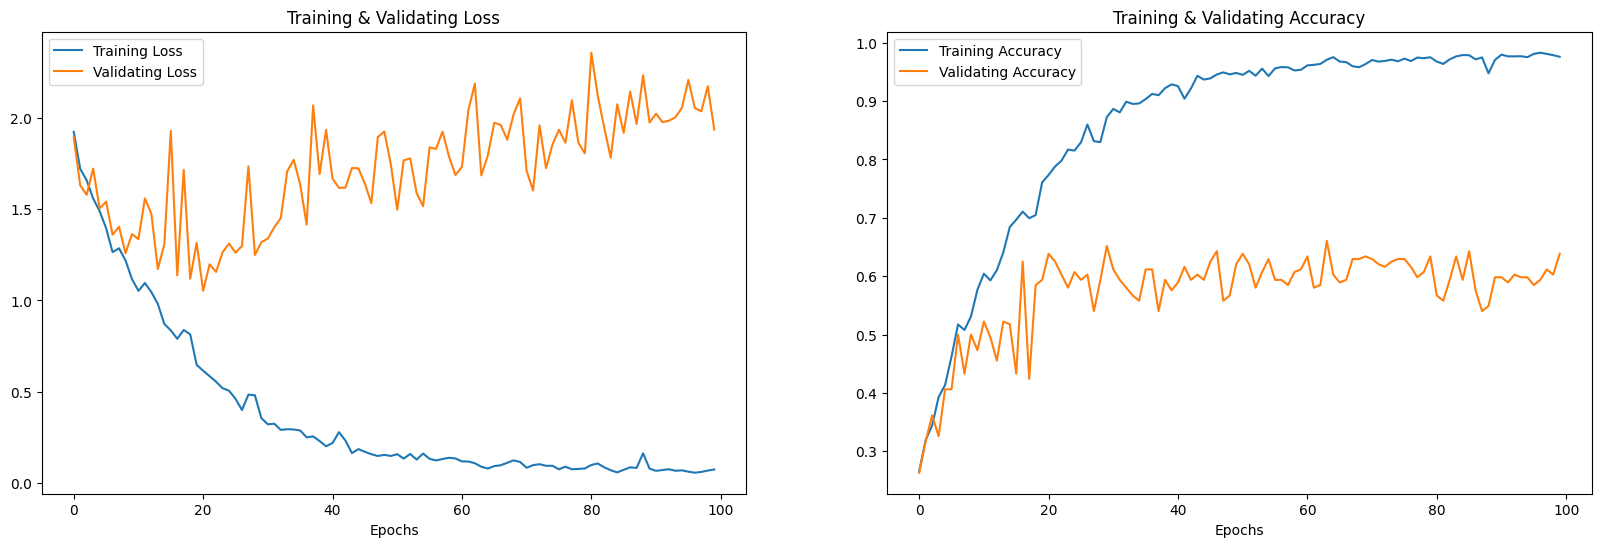

In [39]:
print("Accuracy of our model on validation data : " , model1.evaluate(X_val,y_val)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history2.history['accuracy']
train_loss = history2.history['loss']
val_acc = history2.history['val_accuracy']
val_loss = history2.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , val_loss , label = 'Validating Loss')
ax[0].set_title('Training & Validating Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , val_acc , label = 'Validating Accuracy')
ax[1].set_title('Training & Validating Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

Classification report to provide an overview of the model's performance, including metrics such as precision, recall, F1-score, and support for each class.

In [40]:
y_pred = model1.predict(X_val)
y_pred_ = np.argmax(y_pred, axis = 1)
y_val_ = np.argmax(y_val, axis = 1)
print(classification_report(y_val_, y_pred_))

7/7 [==============================] - 2s 242ms/step
              precision    recall  f1-score   support

           0       0.71      0.53      0.61        32
           1       0.81      0.81      0.81        32
           2       0.76      0.78      0.77        32
           3       0.53      0.62      0.57        32
           4       0.48      0.31      0.38        32
           5       0.53      0.59      0.56        32
           6       0.65      0.81      0.72        32

    accuracy                           0.64       224
   macro avg       0.64      0.64      0.63       224
weighted avg       0.64      0.64      0.63       224



An easy visual inspection of the model's predictions against the ground truth labels.

In [41]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(df['emotion']).reshape(-1,1)).toarray()

# predicting on test data.
pred_val = model1.predict(X_val)
y_pred_ = encoder.inverse_transform(pred_val)
y_val_ = encoder.inverse_transform(y_val)

df_new = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_new['Predicted Labels'] = y_pred_.flatten()
df_new['Actual Labels'] = y_val_.flatten()

df_new

7/7 [==============================] - 2s 265ms/step


Predicted Labels Actual Labels
0              happy          calm
1               fear          calm
2               calm          calm
3               calm          calm
4              happy          calm
..               ...           ...
219         surprise      surprise
220         surprise      surprise
221         surprise      surprise
222         surprise      surprise
223         surprise      surprise

[224 rows x 2 columns]

The resulting heatmap provides a visual representation of the confusion matrix, allowing for a quick understanding of the model's performance. Each cell in the heatmap represents the number of occurrences where the predicted label and the actual label coincide. 

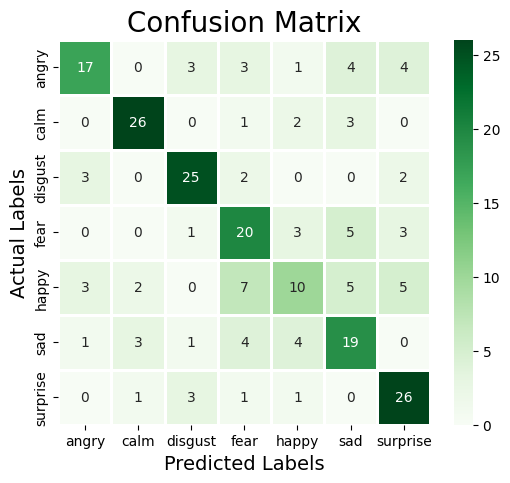

In [42]:
cm = confusion_matrix(y_val_, y_pred_)
plt.figure(figsize = (6, 5))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Greens', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

The top-k accuracy metric evaluates the model's performance by considering whether the true label falls within the k highest predicted labels.

In [43]:
print(top_k_accuracy_score(y_val_, y_pred, k = 2))
print(top_k_accuracy_score(y_val_, y_pred, k = 3))

0.8125
0.9017857142857143


To showcase the model with the best results using augmented data, we will save it in the "Models/Audio_stream" folder for demo purposes.

In [44]:
model1.save('Models/Audio_stream/model1.h5')

In [36]:
X_val = X_train[896:1120]
y_val = y_train[896:1120]
# We don't have to pick the validation data augmented
to_remove = list(range(896, 1120)) + list(range(2016, 2240)) + list(range(3136, 3360)) + list(range(4256, 4480)) + list(range(5376, 5600)) 
X_train = np.delete(X_train, to_remove, axis = 0)
y_train = np.delete(y_train, to_remove, axis = 0)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4480, 128, 184, 1),
 (4480, 7),
 (224, 128, 184, 1),
 (224, 7),
 (224, 128, 184, 1),
 (224, 7))

In [39]:
num_classes = 7

model32 = Sequential()

model32.add(Conv2D(64, (3, 5), activation = 'relu', input_shape = (X_train.shape[1],X_train.shape[2],1)))
model32.add(MaxPooling2D((2, 2)))

model32.add(Conv2D(128, (3, 5), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model32.add(MaxPooling2D((2, 2)))
model32.add(Dropout(0.2))

model32.add(Conv2D(128, (3, 5), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model32.add(GlobalMaxPooling2D())
model32.add(Dropout(0.2))

model32.add(Dense(128, activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model32.add(Dropout(0.2))

model32.add(Dense(num_classes, activation = 'softmax'))

In [41]:
model32.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history32 = model32.fit(X_train, y_train, batch_size = 32, epochs = 30, verbose = 1) 

Epoch 1/30
140/140 [==============================] - 135s 958ms/step - loss: 2.0425 - accuracy: 0.2185
Epoch 2/30
140/140 [==============================] - 136s 973ms/step - loss: 1.9008 - accuracy: 0.2589
Epoch 3/30
140/140 [==============================] - 133s 951ms/step - loss: 1.8327 - accuracy: 0.2922
Epoch 4/30
140/140 [==============================] - 136s 974ms/step - loss: 1.7692 - accuracy: 0.3237
Epoch 5/30
140/140 [==============================] - 133s 952ms/step - loss: 1.6728 - accuracy: 0.3730
Epoch 6/30
140/140 [==============================] - 133s 948ms/step - loss: 1.6110 - accuracy: 0.4094
Epoch 7/30
140/140 [==============================] - 132s 946ms/step - loss: 1.5404 - accuracy: 0.4462
Epoch 8/30
140/140 [==============================] - 134s 957ms/step - loss: 1.4758 - accuracy: 0.4781
Epoch 9/30
140/140 [==============================] - 133s 948ms/step - loss: 1.4273 - accuracy: 0.4987
Epoch 10/30
140/140 [==============================] - 133s 951m

KeyboardInterrupt: 